# **NSEC**

In [1]:
# ================= Block A: Preprocessing =================
# Instructions: run this first. It prepares X_tensor and true_labels.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import torch
from torch.utils.data import Dataset, DataLoader

# Load CSV
data= pd.read_csv("ObesityDataSet.csv")  # Upload the dataset in the collab files section or adjust path/filename if needed
print(data.head())
data['BMI']= data['Weight'] / (data['Height'] ** 2)

# Drop original label and keep features for unsupervised learning
y_raw= data['NObeyesdad'].values
X_raw= data.drop(columns=['NObeyesdad'])

categorical_features= ['Gender','family_history_with_overweight','FAVC','CAEC','SMOKE','SCC','TUE','CALC','MTRANS']
numeric_features= ['Age','Height','Weight','FCVC','NCP','CH2O','FAF','BMI']
ohe_kwargs= {'drop':'first'}
try:
    ohe= OneHotEncoder(sparse_output=False, **ohe_kwargs)
except TypeError:
    ohe= OneHotEncoder(sparse=False, **ohe_kwargs)

# Column transformer
preprocessor= ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ohe, categorical_features)
    ]
)

X_processed= preprocessor.fit_transform(X_raw)

# Label encode
le= LabelEncoder()
true_labels= le.fit_transform(y_raw)
num_clusters= len(np.unique(true_labels))

# Torch tensors & dataloader
X_tensor= torch.tensor(X_processed, dtype=torch.float32)
class TabularDataset(Dataset):
    def __init__(self, X):
        self.X= X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

dataset= TabularDataset(X_tensor)
dataloader= DataLoader(dataset, batch_size=32, shuffle=True)

device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Prepared data shape:", X_processed.shape, "num clusters:", num_clusters)


   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        

In [2]:
# ================= Block B: Autoencoder (AE) Generation for Encoded Data =================
# Instructions: run after Block A.

import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        # Encoder
        self.enc_fc1= nn.Linear(input_dim, 256)
        self.enc_fc2= nn.Linear(256, 128)
        self.enc_fc3= nn.Linear(128, latent_dim)
        # Decoder
        self.dec_fc1= nn.Linear(latent_dim, 128)
        self.dec_fc2= nn.Linear(128, 256)
        self.dec_fc3= nn.Linear(256, input_dim)
        self.act= nn.ReLU()

    def encode(self, x):
        h= self.act(self.enc_fc1(x))
        h= self.act(self.enc_fc2(h))
        z= self.enc_fc3(h)
        return z

    def decode(self, z):
        h= self.act(self.dec_fc1(z))
        h= self.act(self.dec_fc2(h))
        x_hat= self.dec_fc3(h)
        return x_hat

    def forward(self, x):
        z= self.encode(x)
        x_hat= self.decode(z)
        return x_hat, z

def ae_recon_loss(x_hat, x):
    return F.mse_loss(x_hat, x)


In [3]:
# ================= Block C: Pretrain AE =================
# Instructions: run after Block B. Pretrains AE to learn latent structure.

import torch.optim as optim

def pretrain_ae(ae_model, dataloader, epochs=100, lr=1e-3, verbose=True):
    ae_model.to(device)
    optimizer= optim.Adam(ae_model.parameters(), lr=lr, weight_decay=1e-5)
    recon_losses= []
    for epoch in range(1, epochs+1):
        ae_model.train()
        total= 0.0
        for batch in dataloader:
            batch= batch.to(device)
            optimizer.zero_grad()
            x_hat, _= ae_model(batch)
            loss= ae_recon_loss(x_hat, batch)
            loss.backward()
            optimizer.step()
            total += loss.item()*batch.size(0)
        avg= total / len(dataloader.dataset)
        recon_losses.append(avg)
        if verbose and (epoch % 10 == 0 or epoch==1):
            print(f"[AE pretrain] Epoch {epoch}/{epochs}  Recon Loss: {avg:.6f}")
    return recon_losses

# instantiate and pretrain
input_dim= X_tensor.shape[1]
latent_dim= 32            # tuning values I used- 8,16,32
ae_model= AE(input_dim=input_dim, latent_dim=latent_dim)
pretrain_losses= pretrain_ae(ae_model, dataloader, epochs=80, lr=1e-3)


[AE pretrain] Epoch 1/80  Recon Loss: 0.008886
[AE pretrain] Epoch 10/80  Recon Loss: 0.001573
[AE pretrain] Epoch 20/80  Recon Loss: 0.001298
[AE pretrain] Epoch 30/80  Recon Loss: 0.001102
[AE pretrain] Epoch 40/80  Recon Loss: 0.001049
[AE pretrain] Epoch 50/80  Recon Loss: 0.001021
[AE pretrain] Epoch 60/80  Recon Loss: 0.001012
[AE pretrain] Epoch 70/80  Recon Loss: 0.001007
[AE pretrain] Epoch 80/80  Recon Loss: 0.000983


In [4]:
# ================= Block D: Initialize cluster centers =================
# Instructions: run after Block C. This computes initial cluster centers in z-space.

import numpy as np
from sklearn.cluster import KMeans

ae_model.eval()
with torch.no_grad():
    _, z_all= ae_model(X_tensor.to(device))
    z_all= z_all.cpu().numpy()

kmeans= KMeans(n_clusters=num_clusters, n_init=50, random_state=42)
y_pred_init= kmeans.fit_predict(z_all)
cluster_centers= kmeans.cluster_centers_
print("Initialized KMeans cluster centers:", cluster_centers.shape)


Initialized KMeans cluster centers: (7, 32)


In [5]:
# ================= Block E: DEC training (fine-tune AE with clustering loss) =================
# Instructions: run after Block D. This fine-tunes encoder to make clusters tighter.

import torch
import math
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

def soft_assignment(z, cluster_centers, alpha=1.0):
    if isinstance(z, np.ndarray):
        z_t= torch.tensor(z, dtype=torch.float32, device=device)
    else:
        z_t= z.to(device)
    if isinstance(cluster_centers, np.ndarray):
        centers= torch.tensor(cluster_centers, dtype=torch.float32, device=device)
    else:
        centers= cluster_centers.to(device)
    # pairwise squared distances
    # z: (N,D), centers: (K,D) -> dist: (N,K)
    dist= torch.cdist(z_t, centers, p=2) ** 2
    numerator= (1.0+(dist / alpha)) ** (-(alpha+1.0) / 2.0)
    q= numerator / torch.sum(numerator, dim=1, keepdim=True)
    return q

def target_distribution(q):
    weight= (q ** 2) / torch.sum(q, dim=0, keepdim=True)
    p= (weight.t() / torch.sum(weight, dim=1)).t()
    return p

# DEC training loop
def dec_train(ae_model, X_tensor, initial_centers, batch_size=256, maxiter=10000,
              update_interval=140, tol=1e-3, gamma=0.1, lr=1e-3):
    ae_model.to(device)
    optimizer= torch.optim.Adam(ae_model.parameters(), lr=lr, weight_decay=1e-5)
    N= X_tensor.shape[0]
    X_device= X_tensor.to(device)
    # initialize cluster centers tensor
    centers= torch.tensor(initial_centers, dtype=torch.float32, device=device)

    # initial q, p
    ae_model.eval()
    with torch.no_grad():
        _, z= ae_model(X_device)
    q= soft_assignment(z, centers)   # N x K
    p= target_distribution(q).detach()

    # training loop (mini-batch)
    iteration= 0
    prev_y= y_pred_init.copy()
    while iteration < maxiter:
        # create random permutation and process in batches
        idx= np.arange(N)
        np.random.shuffle(idx)
        for start in range(0, N, batch_size):
            if iteration >= maxiter:
                break
            batch_idx= idx[start:start+batch_size]
            x_batch= X_device[batch_idx]
            ae_model.train()
            optimizer.zero_grad()
            x_hat, z_batch= ae_model(x_batch)
            # compute q_batch using current centers
            q_batch= soft_assignment(z_batch, centers)
            # get corresponding p_batch
            p_batch= p[batch_idx]
            # clustering loss: KL divergence KL(P||Q)= sum p*log(p/q)
            eps= 1e-10
            kl_loss= torch.sum(p_batch*torch.log((p_batch+eps) / (q_batch+eps)), dim=1).mean()
            # reconstruction loss
            recon_loss= ae_recon_loss(x_hat, x_batch)
            loss= recon_loss+gamma*kl_loss
            loss.backward()
            optimizer.step()

            iteration += 1

            # update target distribution p every update_interval iterations using the whole dataset
            if iteration % update_interval == 0:
                ae_model.eval()
                with torch.no_grad():
                    _, z_all= ae_model(X_device)
                q_all= soft_assignment(z_all, centers)
                p= target_distribution(q_all).detach()
                # evaluate predicted cluster assignments
                y_pred= torch.argmax(q_all, dim=1).cpu().numpy()
                delta_label= np.sum(y_pred != prev_y).astype(float) / N
                prev_y= y_pred

                if delta_label < tol:
                    print(f"[DEC] Converged (delta_label={delta_label:.6f}) at iter {iteration}")
                    return p, q_all, z_all


    ae_model.eval()
    with torch.no_grad():
        _, z_all= ae_model(X_device)
        q_all= soft_assignment(z_all, centers)
    return p, q_all, z_all

# run DEC fine-tuning
p_final, q_final, z_dec= dec_train(ae_model, X_tensor, cluster_centers,
                                   batch_size=64, maxiter=2000, update_interval=50, tol=1e-4, gamma=1.0, lr=5e-4)
z_dec_np= z_dec.cpu().numpy()


[DEC] Converged (delta_label=0.000000) at iter 1800


NSEC results  -> Silhouette: 0.8905, ARI: 0.3226, NMI: 0.4200


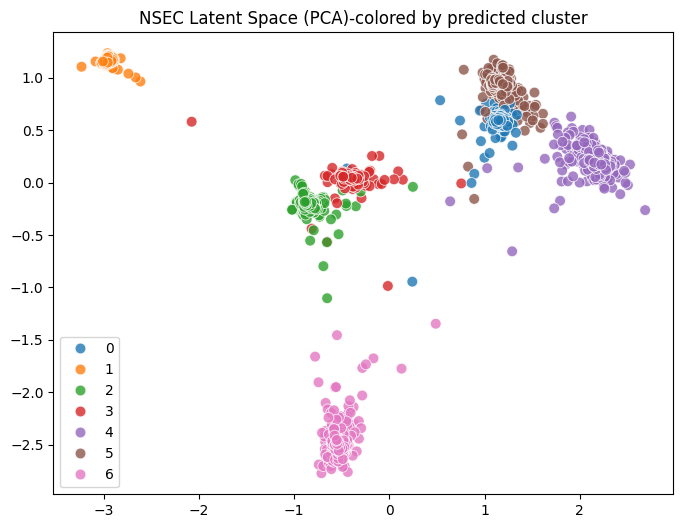

In [6]:
# ================= Block F: Evaluation & Visualization =================
# Instructions: run after Block E.

from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# predicted labels from q_final
pred_labels_dec= torch.argmax(q_final, dim=1).cpu().numpy()

sil_nsec= silhouette_score(z_dec_np, pred_labels_dec)
ari_nsec= adjusted_rand_score(true_labels, pred_labels_dec)
nmi_nsec= normalized_mutual_info_score(true_labels, pred_labels_dec)

print("NSEC results  -> Silhouette: {:.4f}, ARI: {:.4f}, NMI: {:.4f}".format(sil_nsec, ari_nsec, nmi_nsec))

# PCA visualization
pca= PCA(n_components=2)
z_pca= pca.fit_transform(z_dec_np)
plt.figure(figsize=(8,6))
sns.scatterplot(x=z_pca[:,0], y=z_pca[:,1], hue=pred_labels_dec, palette='tab10', s=60, alpha=0.8)
plt.title("NSEC Latent Space (PCA)-colored by predicted cluster")
plt.show()


# **BDC**

Device: cuda
Data prepared | X shape: (2111, 31) | Num clusters: 7
Epoch 010 | Loss: 0.327767 | Recon: 0.293661 | KL: 0.032939
Epoch 020 | Loss: 0.322091 | Recon: 0.250415 | KL: 0.046022
Epoch 030 | Loss: 0.314279 | Recon: 0.255128 | KL: 0.044886
Epoch 040 | Loss: 0.315103 | Recon: 0.274203 | KL: 0.051663
Epoch 050 | Loss: 0.316859 | Recon: 0.257866 | KL: 0.061215
Epoch 060 | Loss: 0.312944 | Recon: 0.256376 | KL: 0.054199
Epoch 070 | Loss: 0.315986 | Recon: 0.255468 | KL: 0.060957
Epoch 080 | Loss: 0.314481 | Recon: 0.239722 | KL: 0.062866
Epoch 090 | Loss: 0.311194 | Recon: 0.257548 | KL: 0.057258
Epoch 100 | Loss: 0.309560 | Recon: 0.239826 | KL: 0.057851
Epoch 110 | Loss: 0.311088 | Recon: 0.238713 | KL: 0.058208
Epoch 120 | Loss: 0.312093 | Recon: 0.273742 | KL: 0.070276
Epoch 130 | Loss: 0.310364 | Recon: 0.223563 | KL: 0.064303
Epoch 140 | Loss: 0.312337 | Recon: 0.239877 | KL: 0.050342
Epoch 150 | Loss: 0.313094 | Recon: 0.247136 | KL: 0.061539
Unique predicted clusters: [0 1 2

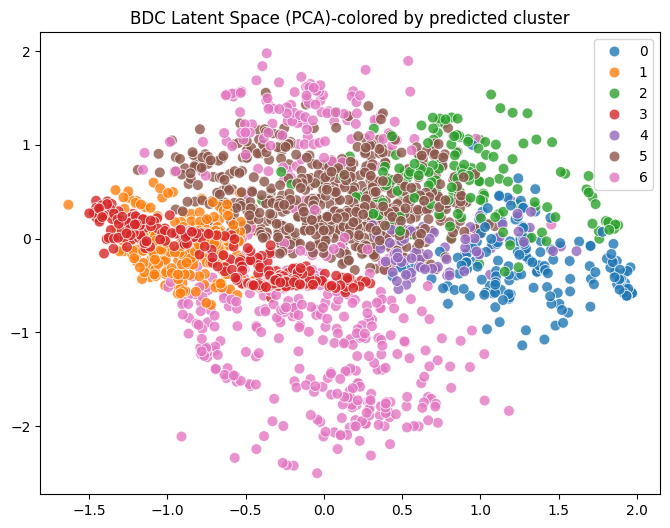

In [7]:
# =================== Bayesian Deep Cluster Pipeline ===================
#Run the entire block
import os, random, numpy as np, pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- Config & Reproducibility -----------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------- Load & Preprocess Data -----------------
DATA_PATH= "ObesityDataSet.csv"
df= pd.read_csv(DATA_PATH)
target_col= "NObeyesdad"
df= df.dropna(how="all")

y_raw= df[target_col].astype(str).copy()
X_df= df.drop(columns=[target_col]).copy()

categorical_cols= X_df.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols= X_df.select_dtypes(include=[np.number]).columns.tolist()

num_pipeline= Pipeline([("imputer", SimpleImputer(strategy="median")),
                         ("scaler", StandardScaler())])
cat_pipeline= Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                         ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))])
preprocessor= ColumnTransformer([("num", num_pipeline, numeric_cols),
                                  ("cat", cat_pipeline, categorical_cols)],
                                 remainder="drop", sparse_threshold=0)
X= preprocessor.fit_transform(X_df)

le= LabelEncoder()
y= le.fit_transform(y_raw)
num_clusters= len(np.unique(y))
print("Data prepared | X shape:", X.shape, "| Num clusters:", num_clusters)

# ----------------- Torch Dataset -----------------
class TabularDataset(Dataset):
    def __init__(self, X_array): self.X= X_array.astype(np.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx]

batch_size= 128
loader= DataLoader(TabularDataset(X), batch_size=batch_size, shuffle=True, drop_last=False)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.enc_fc1= nn.Linear(input_dim, 256)
        self.enc_fc2= nn.Linear(256, 128)
        self.mu_layer= nn.Linear(128, latent_dim)
        self.logvar_layer= nn.Linear(128, latent_dim)
        self.dec_fc1= nn.Linear(latent_dim, 128)
        self.dec_fc2= nn.Linear(128, 256)
        self.dec_fc3= nn.Linear(256, input_dim)
        self.act= nn.LeakyReLU(0.2)
        self.norm1= nn.LayerNorm(256)
        self.norm2= nn.LayerNorm(128)
        self.norm3= nn.LayerNorm(128)
        self.norm4= nn.LayerNorm(256)

    def encode(self, x):
        h= self.act(self.norm1(self.enc_fc1(x)))
        h= self.act(self.norm2(self.enc_fc2(h)))
        mu= self.mu_layer(h)
        logvar= self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std= torch.exp(0.5*logvar)
        eps= torch.randn_like(std)
        return mu+eps*std

    def decode(self, z):
        h= self.act(self.norm3(self.dec_fc1(z)))
        h= self.act(self.norm4(self.dec_fc2(h)))
        return self.dec_fc3(h)

    def forward(self, x):
        mu, logvar= self.encode(x)
        z= self.reparameterize(mu, logvar)
        x_hat= self.decode(z)
        return x_hat, mu, logvar, z

# ----------------- Reconstruction+KL Loss -----------------
def vae_loss(x_hat, x, mu, logvar):
    recon_loss= F.mse_loss(x_hat, x, reduction="mean")
    kl_loss= -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return recon_loss+kl_loss, recon_loss, kl_loss

input_dim= X.shape[1]
latent_dim= 16
vae= VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)

# ----------------- Training -----------------
optimizer= torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
epochs= 150
vae.train()
for epoch in range(1, epochs+1):
    total_loss= 0
    for batch in loader:
        batch= batch.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar, _= vae(batch)
        loss, recon, kl= vae_loss(x_hat, batch, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()*batch.size(0)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {total_loss/len(X):.6f} | Recon: {recon.item():.6f} | KL: {kl.item():.6f}")

# ----------------- Extract Latent Embeddings -----------------
vae.eval()
all_z= []
with torch.no_grad():
    X_tensor= torch.from_numpy(X.astype(np.float32)).to(device)
    for i in range(0, len(X_tensor), 1024):
        batch= X_tensor[i:i+1024]
        _, mu, logvar, z= vae(batch)
        all_z.append(mu.cpu().numpy())
embeddings= np.vstack(all_z)
z_scaled= StandardScaler().fit_transform(embeddings)

# ----------------- PCA for dimensionality reduction -----------------
n_pca= min(10, z_scaled.shape[1], z_scaled.shape[0])
z_pca= PCA(n_components=n_pca, random_state=42).fit_transform(z_scaled)

# ----------------- Bayesian Gaussian Mixture -----------------
bdc= BayesianGaussianMixture(
    n_components=num_clusters,
    covariance_type="diag",
    weight_concentration_prior_type="dirichlet_process",
    max_iter=500,
    random_state=42
)
pred_labels_bdc= bdc.fit_predict(z_pca)
print("Unique predicted clusters:", np.unique(pred_labels_bdc))

# ----------------- Evaluation -----------------
sil_bdc= silhouette_score(embeddings, pred_labels_bdc) if len(np.unique(pred_labels_bdc))>1 else -1
ari_bdc= adjusted_rand_score(y, pred_labels_bdc)
nmi_bdc= normalized_mutual_info_score(y, pred_labels_bdc)
print(f"Bayesian Deep Clustering -> Silhouette: {sil_bdc:.4f}, ARI: {ari_bdc:.4f}, NMI: {nmi_bdc:.4f}")

# ----------------- PCA Visualization -----------------
z_vis= PCA(n_components=2, random_state=42).fit_transform(embeddings)
plt.figure(figsize=(8,6))
sns.scatterplot(x=z_vis[:,0], y=z_vis[:,1], hue=pred_labels_bdc,
                palette='tab10', s=60, alpha=0.8)
plt.title("BDC Latent Space (PCA)-colored by predicted cluster")
plt.show()


# **Model Comparison**



=== Model Comparison Results ===
      Model  Silhouette       ARI       NMI
0      NSEC    0.890456  0.322577  0.419985
1  Bayesian    0.129700  0.251217  0.364615


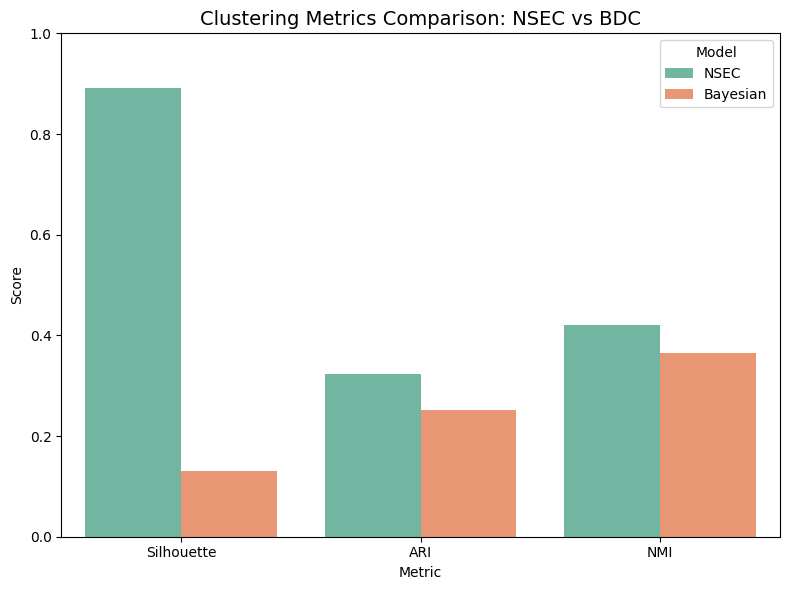

In [8]:
# ================= Block G: Model Comparison (Stats+Visualization) =================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# --- Collect results ---
results= {
    "Model": ["NSEC", "Bayesian"],
    "Silhouette": [sil_nsec, sil_bdc],
    "ARI": [ari_nsec, ari_bdc],
    "NMI": [nmi_nsec, nmi_bdc]
}

df_results= pd.DataFrame(results)
print("\n=== Model Comparison Results ===")
print(df_results)

# --- Bar plot comparison ---
plt.figure(figsize=(8,6))
df_melted= df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette="Set2")

plt.title("Clustering Metrics Comparison: NSEC vs BDC", fontsize=14)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.legend(title="Model")
plt.tight_layout()
plt.show()
